In [ ]:
!pip install scikit-plot
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [ ]:
from google.colab import files
uploaded = files.upload()
df = uploaded
df = pd.read_csv('air_dataset.csv')
df.drop(columns='Unnamed: 0',inplace=True)
class_name = 'weekend'
df.head()

Saving air_dataset.csv to air_dataset.csv


,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [ ]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    df = df.reindex(dfX.index)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
res = prepare_dataset(df, class_name)
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,0,1186.50
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,0,1148.75
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,0,1024.50
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,0,1015.00
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,0,883.25


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score

In [ ]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# Sklearn Multilayer Perceptron

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive',  #2
                    activation='tanh', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7735042735042735
Precision 0.6469072164948454
Recall 0.46654275092936803
F1-score [0.84953868 0.54211663]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1334
           1       0.65      0.47      0.54       538

    accuracy                           0.77      1872
   macro avg       0.73      0.68      0.70      1872
weighted avg       0.76      0.77      0.76      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1197,  137],
       [ 287,  251]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='logistic', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

#merda

Accuracy 0.7126068376068376
Precision 0.0
Recall 0.0
F1-score [0.83218964 0.        ]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1334
           1       0.00      0.00      0.00       538

    accuracy                           0.71      1872
   macro avg       0.36      0.50      0.42      1872
weighted avg       0.51      0.71      0.59      1872



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1334,    0],
       [ 538,    0]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7735042735042735
Precision 0.6122047244094488
Recall 0.5780669144981413
F1-score [0.84284655 0.59464627]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1334
           1       0.61      0.58      0.59       538

    accuracy                           0.77      1872
   macro avg       0.72      0.72      0.72      1872
weighted avg       0.77      0.77      0.77      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1137,  197],
       [ 227,  311]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200, 128, 64, 32), alpha=0.1, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7831196581196581
Precision 0.6103678929765887
Recall 0.6784386617100372
F1-score 0.7434653935885251
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1334
           1       0.61      0.68      0.64       538

    accuracy                           0.78      1872
   macro avg       0.74      0.75      0.74      1872
weighted avg       0.79      0.78      0.79      1872



array([[1101,  233],
       [ 173,  365]])

In [ ]:
clf = MLPClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

#sempre problema recall basso

Accuracy 0.7435897435897436
Precision 0.5993150684931506
Recall 0.3252788104089219
F1-score 0.6284823577081146
              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1334
           1       0.60      0.33      0.42       538

    accuracy                           0.74      1872
   macro avg       0.68      0.62      0.63      1872
weighted avg       0.72      0.74      0.72      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1217,  117],
       [ 363,  175]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.1, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7735042735042735
Precision 0.6122047244094488
Recall 0.5780669144981413
F1-score [0.84284655 0.59464627]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1334
           1       0.61      0.58      0.59       538

    accuracy                           0.77      1872
   macro avg       0.72      0.72      0.72      1872
weighted avg       0.77      0.77      0.77      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1137,  197],
       [ 227,  311]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.1, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7735042735042735
Precision 0.6122047244094488
Recall 0.5780669144981413
F1-score 0.7187464122563701
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1334
           1       0.61      0.58      0.59       538

    accuracy                           0.77      1872
   macro avg       0.72      0.72      0.72      1872
weighted avg       0.77      0.77      0.77      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1137,  197],
       [ 227,  311]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.1, learning_rate='adaptive', 
                    activation='relu', early_stopping=True, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.7377136752136753
Precision 0.5472837022132797
Recall 0.5055762081784386
F1-score 0.6721780859293498
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1334
           1       0.55      0.51      0.53       538

    accuracy                           0.74      1872
   macro avg       0.68      0.67      0.67      1872
weighted avg       0.73      0.74      0.73      1872



array([[1109,  225],
       [ 266,  272]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.001, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

# alpha è: l2 penalty(regularization term) parameter

Accuracy 0.7879273504273504
Precision 0.6447638603696099
Recall 0.5836431226765799
F1-score 0.7333366822450864
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1334
           1       0.64      0.58      0.61       538

    accuracy                           0.79      1872
   macro avg       0.74      0.73      0.73      1872
weighted avg       0.78      0.79      0.78      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1161,  173],
       [ 224,  314]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.01, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

# migliore

Accuracy 0.7948717948717948
Precision 0.6604166666666667
Recall 0.5892193308550185
F1-score 0.7409620232729432
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1334
           1       0.66      0.59      0.62       538

    accuracy                           0.79      1872
   macro avg       0.75      0.73      0.74      1872
weighted avg       0.79      0.79      0.79      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1171,  163],
       [ 221,  317]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.01, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.1, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm


Accuracy 0.7948717948717948
Precision 0.6604166666666667
Recall 0.5892193308550185
F1-score 0.7409620232729432
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1334
           1       0.66      0.59      0.62       538

    accuracy                           0.79      1872
   macro avg       0.75      0.73      0.74      1872
weighted avg       0.79      0.79      0.79      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1171,  163],
       [ 221,  317]])

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc

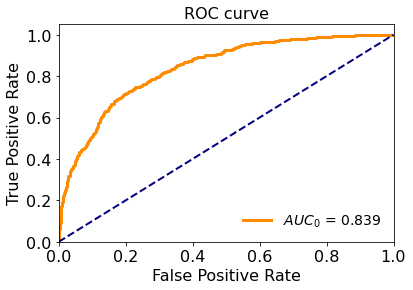

In [ ]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
from scikitplot.metrics import plot_lift_curve

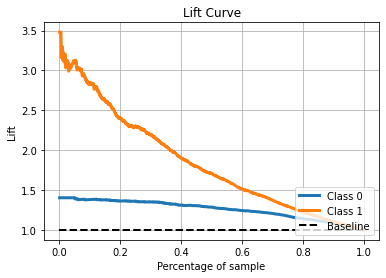

In [ ]:
plot_lift_curve(y_test, y_score)
plt.show()

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.00000001, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm


Accuracy 0.7889957264957265
Precision 0.6492693110647182
Recall 0.5780669144981413
F1-score 0.7333774675402644
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1334
           1       0.65      0.58      0.61       538

    accuracy                           0.79      1872
   macro avg       0.74      0.73      0.73      1872
weighted avg       0.78      0.79      0.79      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1166,  168],
       [ 227,  311]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.1, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm


Accuracy 0.7735042735042735
Precision 0.6122047244094488
Recall 0.5780669144981413
F1-score 0.7187464122563701
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1334
           1       0.61      0.58      0.59       538

    accuracy                           0.77      1872
   macro avg       0.72      0.72      0.72      1872
weighted avg       0.77      0.77      0.77      1872



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([[1137,  197],
       [ 227,  311]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=1, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm


Accuracy 0.7334401709401709
Precision 0.5802469135802469
Recall 0.2620817843866171
F1-score 0.5963325746520358
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1334
           1       0.58      0.26      0.36       538

    accuracy                           0.73      1872
   macro avg       0.67      0.59      0.60      1872
weighted avg       0.71      0.73      0.70      1872



array([[1232,  102],
       [ 397,  141]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=10, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm


Accuracy 0.7126068376068376
Precision 0.0
Recall 0.0
F1-score 0.4160948222083593
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1334
           1       0.00      0.00      0.00       538

    accuracy                           0.71      1872
   macro avg       0.36      0.50      0.42      1872
weighted avg       0.51      0.71      0.59      1872



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1334,    0],
       [ 538,    0]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=100, learning_rate='adaptive', 
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

# merda

Accuracy 0.7126068376068376
Precision 0.0
Recall 0.0
F1-score 0.4160948222083593
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      1334
           1       0.00      0.00      0.00       538

    accuracy                           0.71      1872
   macro avg       0.36      0.50      0.42      1872
weighted avg       0.51      0.71      0.59      1872



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1334,    0],
       [ 538,    0]])

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='identity', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

# identity è lineare infatti i risultati fanno schifo

Accuracy 0.7104700854700855
Precision 0.3888888888888889
Recall 0.013011152416356878
F1-score [0.82998745 0.02517986]
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      1334
           1       0.39      0.01      0.03       538

    accuracy                           0.71      1872
   macro avg       0.55      0.50      0.43      1872
weighted avg       0.62      0.71      0.60      1872



array([[1323,   11],
       [ 531,    7]])

Accuracy 0.7104700854700855
Precision 0.3888888888888889
Recall 0.013011152416356878
F1-score [0.82998745 0.02517986]
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      1334
           1       0.39      0.01      0.03       538

    accuracy                           0.71      1872
   macro avg       0.55      0.50      0.43      1872
weighted avg       0.62      0.71      0.60      1872



array([[1323,   11],
       [ 531,    7]])

## Gridsearch

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [ ]:
# ci mette troppo tempo. non rifare
parameters = {'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
'activation': ["logistic", "relu", "Tanh","adam"], 'alpha': 10.0 ** -np.arange(1, 10),}

mlpc = MLPClassifier()
search = GridSearchCV(mlpc, parameters,cv = 4)
search.fit(X_train, y_train)
report(search.cv_results_, n_top=3)

In [ ]:
clf = search.best_estimator_
clf

In [ ]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

In [ ]:
plt.matshow(cm)
plt.title('Confusion matrix\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum", "adam"]

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
for label, param in zip(labels, params):
    print(label)
    clf = MLPClassifier(random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X, y)

    print("training set score and loss: %.3f, %f" % (clf.score(X, y), clf.loss_))
    plt.plot(clf.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()